### Cell 1: Imports

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Scikit-learn for ML and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score
from scipy.stats import randint

# TensorFlow / Keras for Deep Neural Network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Saving models
import joblib
import os

# Oversampling for class imbalance
from imblearn.over_sampling import ADASYN

# Suppress warnings
warnings.filterwarnings("ignore")

### Cell 2: Load filtered dataset

In [2]:
# Load the cleaned and feature-filtered dataset
df = pd.read_csv('../data/selected_expression_data.csv')
X = df.drop(columns=["label"])
y = df["label"]

### Cell 3: Train-test split

In [3]:
# Split the data into training and testing sets (stratified for label balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

# Scale data separately for each model (important for reproducibility and tracking)
# For Baseline RF
scaler_baseline = StandardScaler()
X_train_scaled_baseline = scaler_baseline.fit_transform(X_train)
X_test_scaled_baseline = scaler_baseline.transform(X_test)

# For GridSearch RF
scaler_grid = StandardScaler()
X_train_scaled_grid = scaler_grid.fit_transform(X_train)
X_test_scaled_grid = scaler_grid.transform(X_test)

# For RandomSearch RF
scaler_random = StandardScaler()
X_train_scaled_random = scaler_random.fit_transform(X_train)
X_test_scaled_random = scaler_random.transform(X_test)


Train size: (228, 70), Test size: (58, 70)


### Cell 4: Helper function to compute evaluation metrics

In [4]:
# Helper function to return evaluation scores
def get_metrics(y_true, y_pred, y_probs):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "ROC AUC": roc_auc_score(y_true, y_probs)
    }

### Cell 5: Random forest classifier

In [5]:
# Train random forest classifier
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train_scaled_baseline, y_train)

# Predict on test set
y_pred_rf = rf.predict(X_test_scaled_baseline)

# Evaluate baseline model performance
print("Baseline Random Forest Results")
print(classification_report(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, rf.predict_proba(X_test_scaled_baseline)[:, 1]))

Baseline Random Forest Results
              precision    recall  f1-score   support

           0       0.78      0.95      0.86        44
           1       0.50      0.14      0.22        14

    accuracy                           0.76        58
   macro avg       0.64      0.55      0.54        58
weighted avg       0.71      0.76      0.70        58

F1 Score: 0.2222222222222222
ROC AUC: 0.6607142857142857


### Cell 6: Random Forest Tuning with GridSearchCV

In [6]:
# Define parameter grid with wider hyperparameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search with class_weight and macro scoring
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid,
    scoring='f1_macro',  # Use 'roc_auc' alternatively
    cv=5,
    n_jobs=-1
)

# Fit to training data
grid_search.fit(X_train_scaled_grid, y_train)
gridSearchRF = grid_search.best_estimator_

# Show best parameters
print("Best parameters from GridSearchCV:", grid_search.best_params_)


Best parameters from GridSearchCV: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


### Cell 7: Evaluate tuned random forest (GridSearchCV)

In [7]:
# Evaluate best-tuned random forest
y_pred_gridSearchRF = gridSearchRF.predict(X_test_scaled_grid)

print("Tuned Random Forest Results")
print(classification_report(y_test, y_pred_gridSearchRF))
print("F1 Score:", f1_score(y_test, y_pred_gridSearchRF))
print("ROC AUC:", roc_auc_score(y_test, gridSearchRF.predict_proba(X_test_scaled_grid)[:, 1]))

Tuned Random Forest Results
              precision    recall  f1-score   support

           0       0.81      0.89      0.85        44
           1       0.50      0.36      0.42        14

    accuracy                           0.76        58
   macro avg       0.66      0.62      0.63        58
weighted avg       0.74      0.76      0.74        58

F1 Score: 0.4166666666666667
ROC AUC: 0.6525974025974026


### Cell 8: Random forest tuning with RandomizedSearchCV

In [8]:
# Advanced hyperparameter tuning using RandomizedSearchCV

param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [5, 10, 20, 30, None],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
}

rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train_scaled_random, y_train)
randomSearchRF = random_search.best_estimator_

print("Best parameters from RandomizedSearchCV:", random_search.best_params_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters from RandomizedSearchCV: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 221}


### Cell 9: Evaluate RandomizedSearchCV random forest model

In [9]:
# Evaluation of RandomizedSearchCV-tuned model
y_pred_randomSearchRF = randomSearchRF.predict(X_test_scaled_random)

print("Tuned RF (RandomizedSearchCV) Results")
print(classification_report(y_test, y_pred_randomSearchRF))
print("F1 Score:", f1_score(y_test, y_pred_randomSearchRF))
print("ROC AUC:", roc_auc_score(y_test, randomSearchRF.predict_proba(X_test_scaled_random)[:, 1]))

metrics_rf_random =  get_metrics(y_test, y_pred_randomSearchRF, randomSearchRF.predict_proba(X_test_scaled_random)[:, 1])

Tuned RF (RandomizedSearchCV) Results
              precision    recall  f1-score   support

           0       0.80      0.91      0.85        44
           1       0.50      0.29      0.36        14

    accuracy                           0.76        58
   macro avg       0.65      0.60      0.61        58
weighted avg       0.73      0.76      0.73        58

F1 Score: 0.36363636363636365
ROC AUC: 0.6834415584415584


### Cell 10: Compare all random forest models

In [10]:
# Helper function to compute all metrics
def get_metrics(y_true, y_pred, y_probs):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "ROC AUC": roc_auc_score(y_true, y_probs)
    }

# Collect metrics for all three models
metrics = {
    "Baseline RF": get_metrics(y_test, y_pred_rf, rf.predict_proba(X_test_scaled_baseline)[:, 1]),
    "GridSearch RF": get_metrics(y_test, y_pred_gridSearchRF, grid_search.best_estimator_.predict_proba(X_test_scaled_grid)[:, 1]),
    "RandomSearch RF": get_metrics(y_test, y_pred_randomSearchRF, randomSearchRF.predict_proba(X_test_scaled_random)[:, 1])
}

# Convert to long-form DataFrame for seaborn plotting
metrics_df = pd.DataFrame(metrics).T.round(3)
metrics_long = metrics_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')
metrics_long.rename(columns={'index': 'Model'}, inplace=True)

# Display table
display(metrics_df)

,Accuracy,F1,Precision,Recall,ROC AUC
Baseline RF,0.759,0.222,0.5,0.143,0.661
GridSearch RF,0.759,0.417,0.5,0.357,0.653
RandomSearch RF,0.759,0.364,0.5,0.286,0.683


### Model Evaluation Summary
Across all three Random Forest models — **Baseline**, **GridSearchCV-tuned**, and **RandomizedSearchCV-tuned** — the overall accuracy remains constant at 0.76. However, this metric overstates performance due to the significant class imbalance in the dataset. In this case, consistently predicting the majority class (non-relapse) yields high accuracy, but it fails to meaningfully detect the minority class (relapse).

Key takeaways:
- **F1 Score** improved from 0.22 (Baseline) to 0.42 (GridSearchCV) and 0.36 (RandomSearchCV), suggesting that hyperparameter tuning helps optimize the balance between precision and recall.
- **Recall**, which is especially important for identifying relapse cases, improved from 0.14 in the baseline model to 0.36 (GridSearchCV) and 0.29 (RandomSearchCV) — an encouraging sign, though still insufficient for clinical application.
- **Precision** remained constant across all three models (0.50), indicating that while more relapse cases are being captured (↑ Recall), the proportion of true positives among those predictions is stable.
- **ROC AUC** showed a slight improvement in the RandomizedSearchCV model (0.68) compared to the baseline (0.66), reflecting modest gains in the model's discriminative ability.

While tuning helped, the model is still limited in sensitivity toward the minority class. As a result, the next section will prioritize addressing class imbalance, experimenting with:

- `class_weight='balanced'` and
- advanced sampling strategies (e.g., ADASYN)

These strategies aim to boost recall and F1 without severely compromising precision, helping create a model that can reliably flag relapse patients in a high-stakes clinical context.

### Cell 11: Comparison of random forest models with barplots

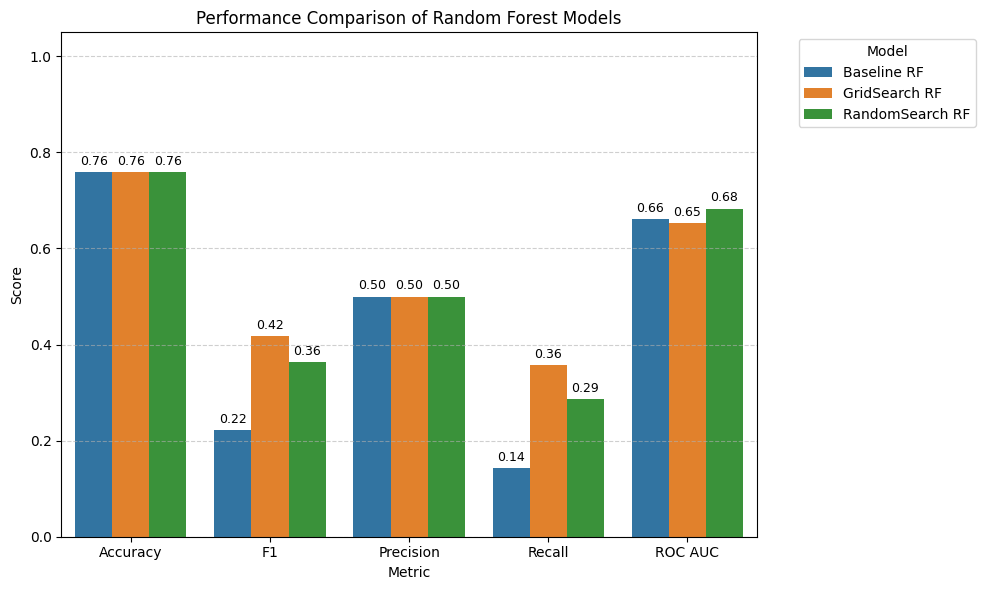

In [11]:
# Bar plot with value labels
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=metrics_long, x='Metric', y='Score', hue='Model')

plt.title("Performance Comparison of Random Forest Models")
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.xlabel("Metric")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')

# Add value labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    if np.isnan(height) or height == 0:
        continue
    ax.annotate(f'{height:.2f}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', 
                fontsize=9, color='black', 
                xytext=(0, 3), textcoords='offset points')

plt.tight_layout()
plt.show()

### Cell 12: Train `class_weight='balanced'` RF with `RandomizedSearchCV`

In [12]:
# Standardize training data
scaler_weighted = StandardScaler()
X_train_weighted = scaler_weighted.fit_transform(X_train)
X_test_weighted = scaler_weighted.transform(X_test)

# Define class-weighted Random Forest model
rf_weighted = RandomForestClassifier(class_weight="balanced", random_state=42)

# Define search space
param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 5, 10]
}

# Randomized search for best hyperparameters
search_weighted = RandomizedSearchCV(
    rf_weighted, param_distributions=param_dist, n_iter=10,
    cv=3, scoring="f1", n_jobs=-1, random_state=42
)
search_weighted.fit(X_train_weighted, y_train)

# Evaluate class-weighted model
y_pred_weighted = search_weighted.best_estimator_.predict(X_test_weighted)
y_prob_weighted = search_weighted.best_estimator_.predict_proba(X_test_weighted)[:, 1]
metrics_rf_weighted = get_metrics(y_test, y_pred_weighted, y_prob_weighted)

### Cell 13: Train `ADASYN` RF with `RandomizedSearchCV`

In [13]:
# Scale training and test data
scaler_adasyn = StandardScaler()
X_train_scaled_adasyn = scaler_adasyn.fit_transform(X_train)
X_test_scaled_adasyn = scaler_adasyn.transform(X_test)

# Apply ADASYN to the training data
adasyn = ADASYN(random_state=42)
X_resampled_adasyn, y_resampled_adasyn = adasyn.fit_resample(X_train_scaled_adasyn, y_train)

# Define hyperparameter grid
param_dist_adasyn = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Initialize and fit Random Forest with randomized search
rf_adasyn = RandomForestClassifier(random_state=42)
random_search_adasyn = RandomizedSearchCV(
    estimator=rf_adasyn,
    param_distributions=param_dist_adasyn,
    n_iter=10,
    cv=5,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)
random_search_adasyn.fit(X_resampled_adasyn, y_resampled_adasyn)

# Predict and evaluate
y_pred_adasyn = random_search_adasyn.predict(X_test_scaled_adasyn)
y_prob_adasyn = random_search_adasyn.predict_proba(X_test_scaled_adasyn)[:, 1]
metrics_rf_adasyn = get_metrics(y_test, y_pred_adasyn, y_prob_adasyn)

  File "C:\Users\chhua\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

### Cell 14: Compare metrics of all three models

In [14]:
# Collect all metrics into a DataFrame
comparison_df = pd.DataFrame({
    "RandomSearchCV RF": metrics_rf_random,
    "Class-Weighted RandomSearchCV RF": metrics_rf_weighted,
    "ADASYN RandomSearchCV RF": metrics_rf_adasyn
}, index=["Accuracy", "F1", "Precision", "Recall", "ROC AUC"]).T

display(comparison_df)

,Accuracy,F1,Precision,Recall,ROC AUC
RandomSearchCV RF,0.758621,0.363636,0.500000,0.285714,0.683442
Class-Weighted RandomSearchCV RF,0.706897,0.484848,0.421053,0.571429,0.660714
ADASYN RandomSearchCV RF,0.689655,0.250000,0.300000,0.214286,0.620130


### Models Evaluation Summary
This analysis evaluated the effectiveness of class balancing strategies for improving Random Forest performance in the presence of significant class imbalance. All models were optimized using `RandomizedSearchCV`:
- **RandomSearchCV RF**: Baseline tuned Random Forest without class balancing.
- **Class-Weighted RF**: Applied `class_weight="balanced"` to adjust for imbalance during training.
- **ADASYN RF**: Used ADASYN to synthetically oversample the minority class prior to training.

Key Observations:
- Class-Weighted RF achieved the highest F1 Score (0.48) and Recall (0.57) — indicating significant improvement in detecting the minority class (relapse), with only a modest drop in precision and accuracy.
- RandomSearchCV RF still maintained the highest ROC AUC (0.68), suggesting stronger overall class discrimination.
- ADASYN RF performed worse across all metrics, especially in F1 (0.25), Recall (0.21), and ROC AUC (0.62), likely due to noise introduced by synthetic samples in high-dimensional space.

Conclusion:
The Class-Weighted Random Forest is the most balanced and effective choice in this comparison. It offers meaningful gains in minority class recall and F1, with minimal trade-offs. This makes it a strong candidate for clinical prediction tasks where correctly identifying relapse cases is critical.

Next Steps:
Given these insights, the next modeling phase will transition to **XGBoost**, which offers advanced control over imbalance handling (e.g., `scale_pos_weight`) and may further enhance recall and overall model robustness.

### Cell 15: Plot model performance

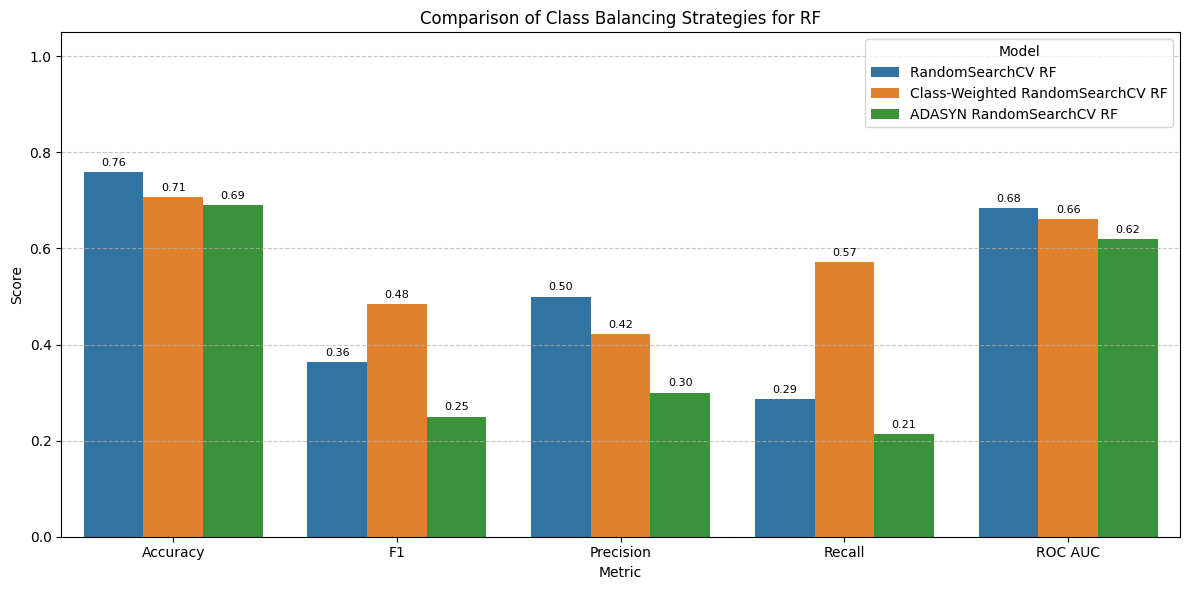

In [15]:
# Reshape data for grouped bar plot
comparison_long = comparison_df.reset_index().melt(id_vars="index", var_name="Metric", value_name="Score")
comparison_long.rename(columns={"index": "Model"}, inplace=True)

# Create barplot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=comparison_long, x="Metric", y="Score", hue="Model")

# Annotate scores on top of each bar
for p in ax.patches:
    height = p.get_height()
    if np.isnan(height) or height == 0:
            continue
    ax.annotate(f'{height:.2f}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=8, color='black',
                xytext=(0, 3), textcoords='offset points')

# Final plot settings
plt.title("Comparison of Class Balancing Strategies for RF")
plt.ylim(0, 1.05)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

### Cell 16: Export models

In [16]:
# Create output directory if it doesn't exist
os.makedirs('../models', exist_ok=True)
os.makedirs('../scalers', exist_ok=True)

# Save models
joblib.dump(gridSearchRF, '../models/rf_gridsearch_model.pkl')
joblib.dump(randomSearchRF, '../models/rf_randomsearch_model.pkl')
joblib.dump(rf, '../models/rf_baseline_model.pkl')
joblib.dump(search_weighted.best_estimator_, "../models/rf_class_weighted.pkl")
joblib.dump(scaler_weighted, "../models/scaler_class_weighted.pkl")

# Save associated scalers
joblib.dump(scaler_grid, '../scalers/scaler_gridsearch.pkl')
joblib.dump(scaler_random, '../scalers/scaler_randomsearch.pkl')
joblib.dump(scaler_baseline, '../scalers/scaler_baseline.pkl')
joblib.dump(random_search_adasyn, "../scalers/rf_adasyn_model.pkl")
joblib.dump(scaler_adasyn, "../scalers/scaler_adasyn.pkl")

print("All models have been saved to `models` and all scalers have been saved to `scalers`.")

All models have been saved to `models` and all scalers have been saved to `scalers`.
